In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import cv2
from skimage import feature
import copy

In [ ]:
!wget 'http://files.fast.ai/data/cifar10.tgz'
!tar -xf cifar10.tgz

--2020-07-29 07:47:58--  http://files.fast.ai/data/cifar10.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168168549 (160M) [application/x-gtar-compressed]
Saving to: ‘cifar10.tgz’

cifar10.tgz         100%[===================>] 160.38M  16.4MB/s    in 11s     

2020-07-29 07:48:10 (14.5 MB/s) - ‘cifar10.tgz’ saved [168168549/168168549]



In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_device()

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
data_dir = '/content/cifar10'

print(os.listdir(data_dir))
classes = sorted(os.listdir(data_dir + "/train"))
print(classes)

['train', 'test', 'labels.txt']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor()])
dataset = ImageFolder(data_dir+'/train',   transform=data_transform)

In [ ]:
len(dataset)

50000

In [ ]:
def split_indices(n, val_pct, seed):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Set the random seed (for reproducibility)
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [ ]:
val_pct = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)
print(len(train_indices), len(val_indices))
print('Sample validation indices: ', val_indices[:10])

40000 10000
Sample validation indices:  [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [ ]:
batch_size=128

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                      batch_size, 
                      sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                    batch_size, 
                    sampler=val_sampler)

Label:  airplane


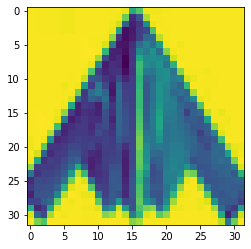

In [ ]:
img,label = dataset[1500]
print("Label: ",classes[label])
plt.imshow(np.array(img.squeeze()))


Label:  dog


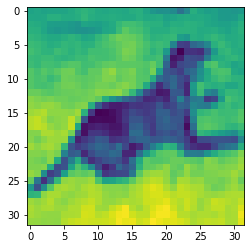

In [ ]:
img,label = dataset[25369]
print("Label: ",classes[label])
plt.imshow(np.array(img.squeeze()))

In [ ]:
class finding_LBP():
  def __init__(self, points, rad):
    self.points = points
    self.rad = rad

  def describe(self, image, eps=1e-10):
    lbp = feature.local_binary_pattern(image, self.points,self.rad, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, self.points + 3),range=(0, self.points + 2))
    lbp = (lbp - lbp.min()) / (lbp.max() - lbp.min())
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    return lbp,hist

In [ ]:
# lbp = finding_LBP(24,8)
lbpx = finding_LBP(24,1)

Label:  dog


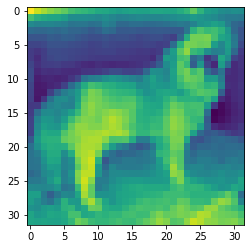

In [ ]:
img,label = dataset[25375]
print("Label: ",classes[label])
plt.imshow(np.array(img.squeeze()))
arr,hist = lbpx.describe(np.array(img.squeeze()))
# arr2,hist2 = lbp2.describe(np.array(img.squeeze()))

Hist: [0.03808594 0.03613281 0.02636719 0.01464844 0.01367187 0.01757812
 0.02148437 0.02441406 0.02734375 0.04296875 0.05761719 0.09667969
 0.10644531 0.09863281 0.0625     0.04882812 0.03417969 0.0234375
 0.02148437 0.02050781 0.01269531 0.01074219 0.01367187 0.01074219
 0.03320312 0.0859375 ]


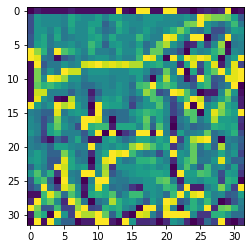

In [ ]:
print('Hist:',hist)
plt.imshow(arr)

In [ ]:
# print('Hist:',hist2)
# plt.imshow(arr2)

In [ ]:
def batchLbp(batch,lbpobj):
  images,labels = batch
  # print('images shape:',images.shape)
  # print('lbls shape:',labels.shape)
  histfeats = []
  lbpfeats = []
  for i in images:
    arr,hist = lbpobj.describe(i.squeeze())
    lbpfeats.append(arr)
    histfeats.append(hist)
  hfeats=torch.as_tensor(np.array(histfeats,dtype='float32'))
  lfeats=torch.as_tensor(np.array(lbpfeats,dtype='float32'))
  # print(lfeats)
  # print(type(labels))
  # print(lfeats.view(-1,32*32).shape)
  # data = (lfeats,labels)
  data = (hfeats,labels)
  data = to_device(data,device)
  return data


In [ ]:
# lbpx = finding_LBP(12,4)
# for batch in train_dl:
#   d=batchLbp(batch,lbpx)
#   break

In [ ]:
class CifarModel(nn.Module):

  def __init__(self,input_size,hidden_size,out_size,lbpobj):
    super().__init__()
    self.lbpobj = lbpobj
    self.linear1 = nn.Linear(input_size,hidden_size)
    self.linear2 = nn.Linear(hidden_size,out_size)

  def forward(self,vb):
    # vb = vb.view(vb.size(0),-1)
    vb = vb.view(-1,input_size)
    # print('vbow shape:',vb.shape)
    out = self.linear1(vb)
    out = F.relu(out)
    # out = torch.sigmoid(out)
    out = self.linear2(out)
    return out

  def training_step(self,batch):
    d = batchLbp(batch,self.lbpobj)
    hfeats,labels = d
    out = self(hfeats)
    acc = accuracy(out,labels)
    # print('Out shape:',out.shape)
    # print('labels shape:',labels.shape)
    loss = F.cross_entropy(out,labels)
    return loss,acc

  def validation_step(self,batch):
    d = batchLbp(batch,self.lbpobj)
    hfeats,labels = d
    out = self(hfeats)
    # print('Out shape:',out.shape)
    # print('labels shape:',labels.shape)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss' : loss, 'val_acc' : acc }

  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item() }
    
  # def epoch_end(epoch, result2):
  #     # print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, result1['val_loss'], result1['val_acc']))
  #     print("val_loss: {:.4f}, val_acc: {:.4f}".format(result2['val_loss'], result2['val_acc']))


In [ ]:
lbpraadius = 1
lbppoints = 24 * max(lbpraadius,1)
lbp = finding_LBP(lbppoints,lbpraadius)
# input_size = 32*32
input_size = lbppoints + 2
num_classes = len(classes)

model = CifarModel(input_size, hidden_size=16,out_size=num_classes,lbpobj=lbp)

to_device(model, device)

CifarModel(
  (linear1): Linear(in_features=26, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
def accuracy(outputs,labels):
  _,preds =  torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
def evaluate(model, valid_loader):
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def fit(model,train_loader,valid_loader,epochs,opt,lr_scheduler):
  history = []  
  best_model_params = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    train_stats = []
    # train_result ={}
    train_acc = 0.0
    #For Training
    for batch in train_loader:
      opt.zero_grad()
      loss,acc = model.training_step(batch)
      train_acc = acc
      loss.backward()
      opt.step()
      train_stats.append({'val_loss' : loss, 'val_acc' : train_acc })

    
    
    train_result = model.validation_epoch_end(train_stats)
    # print(train_result)
    
    #For validation
    valid_result = evaluate(model, valid_loader)

    # lr_scheduler.step()

    if(epoch+1)%4==0:
      print("epoch: {}, training_loss: {:.4f}, training_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, train_result['val_loss'], train_result['val_acc'], valid_result['val_loss'], valid_result['val_acc']))
      # model.epoch_end(epoch+1,valid_result)
    
    history.append(valid_result)
    
    if best_acc < valid_result['val_acc']:
      best_model_params = copy.deepcopy(model.state_dict())
      best_acc = valid_result['val_acc']

  model.load_state_dict(best_model_params)
  return model, history    


In [ ]:
from torch.optim import lr_scheduler
lr = 0.005
opt = torch.optim.Adam(model.parameters(),lr)  
scheduler = lr_scheduler.StepLR(opt, step_size=15, gamma=0.1)

In [ ]:
model, history = fit(model,train_dl,val_dl,40,opt,lr_scheduler=scheduler)

epoch: 4, training_loss: 2.0435, training_acc: 0.2552, val_loss: 2.0311, val_acc: 0.2606
epoch: 8, training_loss: 1.9902, training_acc: 0.2711, val_loss: 1.9773, val_acc: 0.2763
epoch: 12, training_loss: 1.9686, training_acc: 0.2818, val_loss: 1.9622, val_acc: 0.2773
epoch: 16, training_loss: 1.9543, training_acc: 0.2904, val_loss: 1.9433, val_acc: 0.2988
epoch: 20, training_loss: 1.9455, training_acc: 0.2947, val_loss: 1.9349, val_acc: 0.2979
epoch: 24, training_loss: 1.9413, training_acc: 0.2976, val_loss: 1.9309, val_acc: 0.3006
epoch: 28, training_loss: 1.9392, training_acc: 0.2971, val_loss: 1.9295, val_acc: 0.3000
epoch: 32, training_loss: 1.9379, training_acc: 0.2994, val_loss: 1.9297, val_acc: 0.2980
epoch: 36, training_loss: 1.9360, training_acc: 0.2977, val_loss: 1.9279, val_acc: 0.3007
epoch: 40, training_loss: 1.9353, training_acc: 0.2994, val_loss: 1.9275, val_acc: 0.2999


In [ ]:
# for i in range(15,22):
#   print('Batch size:{}, Hidden Layer:{} and Epoch: 60 and lr: 0.5 '.format(batch_size,i))
#   model = CifarModel(input_size, hidden_size=i,out_size=num_classes,lbpobj=lbp)
#   to_device(model, device)
#   history = fit(model,train_dl,val_dl,60,torch.optim.SGD,0.5)


In [ ]:
for parameter in model.parameters():
  print(parameter)

Parameter containing:
tensor([[ 5.6957e-03, -2.4442e-01, -3.6111e-02, -2.1891e-01, -1.5115e-01,
         -1.5822e-01, -2.8770e-01, -2.5308e-01, -1.2156e-02, -9.4387e-02,
          6.1346e-02,  1.0209e-01, -1.6819e-01, -2.0117e-01,  5.4380e-03,
         -2.9251e-01, -2.6020e-01, -2.4157e-01, -2.1717e-01, -3.2590e-02,
         -2.6265e-01, -2.4861e-02, -2.0599e-01,  1.4297e-01, -3.0694e-02,
          2.9027e-02],
        [-1.6574e-01, -1.8389e-01, -5.8107e-02,  2.0793e-02,  1.2570e-01,
         -7.6518e-02,  6.0819e-02, -1.5882e-01,  1.2249e-01,  2.5469e-02,
          9.1349e-02, -3.7328e-02, -1.2645e-01,  2.2776e-03,  1.6367e-01,
          4.2980e-02, -1.3123e-01,  1.7137e-01,  1.0655e-01,  1.0997e-01,
         -4.0348e-02,  1.4661e-01, -1.8984e-01, -1.2086e-01, -2.5663e-02,
          1.0019e-01],
        [ 4.7498e-02, -3.4703e-04, -1.1229e-01, -4.6801e-02,  7.0728e-02,
         -9.9431e-02, -9.5525e-02, -1.6660e-01,  6.2139e-04, -1.7792e-01,
         -1.7290e-01, -1.1498e-01, -3.2653e-

In [ ]:
torch.save(model.state_dict(),'cifar_lbp.pth')

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=data_transform)

In [ ]:
test_dl = DataLoader(test_dataset, batch_size=256)

In [ ]:
test_result = evaluate(model,test_dl)

In [ ]:
print("test_loss: {:.4f}, test_acc: {:.4f}".format(test_result['val_loss'], test_result['val_acc']))

test_loss: 1.9264, test_acc: 0.3029
